Datayı ve Kütüphaneleri importlama

In [1]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Cora veri setini yükleme ve özelliklerini normalleştirme
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Torch ile nn yapısını oluşturuyorum:

In [2]:


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()
print(model)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Optimizasyon algoritmasının parametrelerini ve train testi tanımlıyorum 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs



Epoch: 001, Loss: 1.9459, Train Acc: 0.3857, Val Acc: 0.3480, Test Acc: 0.3670
Epoch: 101, Loss: 0.5938, Train Acc: 0.9929, Val Acc: 0.8040, Test Acc: 0.7990


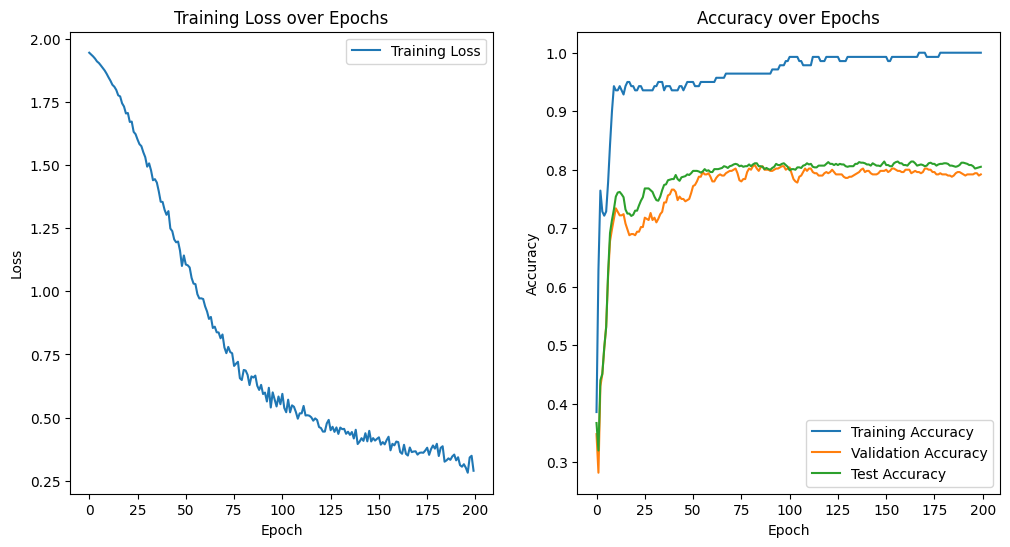

In [4]:

# Eğitim ve değerlendirme sonuçlarını saklamak için listeler oluşturun
train_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Eğitim ve değerlendirme döngüsü
for epoch in range(0,200):
    loss = train()
    train_acc, val_acc, test_acc = test()
    train_losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    if epoch%100==0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

# Grafik çizimi
plt.figure(figsize=(12, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()


Graph çiziyorum

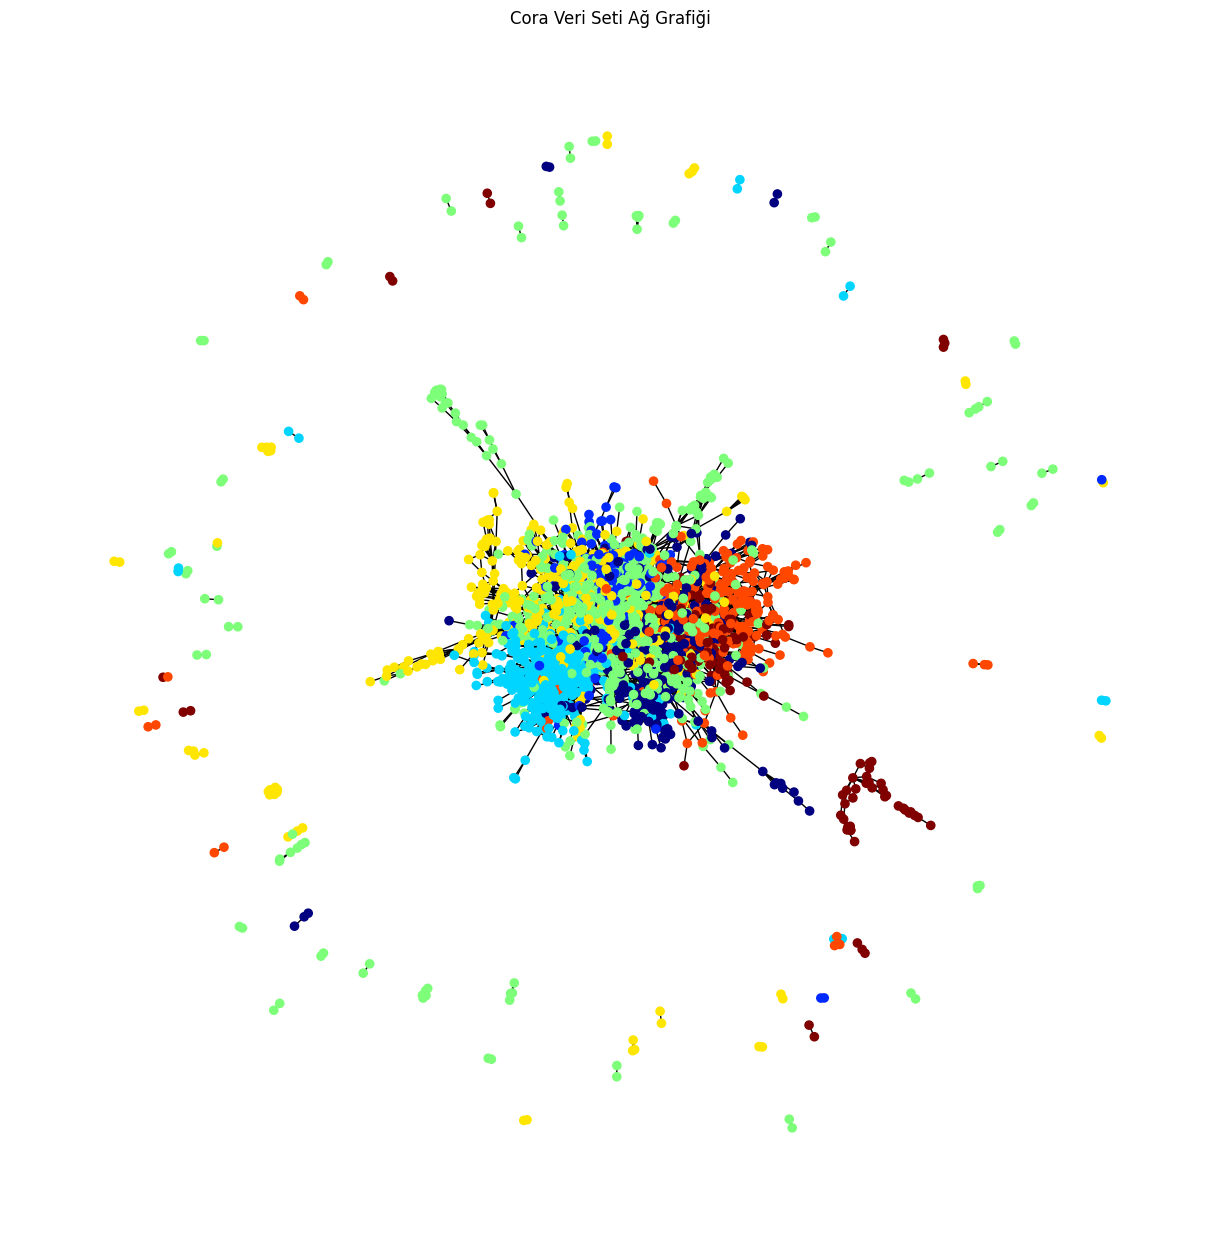

In [5]:
# Cora veri setini bir NetworkX grafiğine dönüştür
G = to_networkx(data, to_undirected=True)

# Düğüm renklerini sınıflarına göre belirle
colors = [data.y[i].item() for i in range(data.num_nodes)]

# Grafiği çiz
plt.figure(figsize=(12, 12))
nx.draw(G, node_color=colors, node_size=35, cmap=plt.cm.jet, with_labels=False)
plt.title('Cora Veri Seti Ağ Grafiği')
plt.show()


Buraya kadarki kodun aynısı sadece parametreleri optimize ediyorum düşük learning rate yüksek epoch ve daha fazla layer ile modelin performansını arttırıyorum

GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 001, Loss: 1.9454, Train Acc: 0.4500, Val Acc: 0.2660, Test Acc: 0.2790
Epoch: 201, Loss: 0.3558, Train Acc: 0.9929, Val Acc: 0.7960, Test Acc: 0.8180
Epoch: 401, Loss: 0.2053, Train Acc: 1.0000, Val Acc: 0.7940, Test Acc: 0.8110
Epoch: 601, Loss: 0.1656, Train Acc: 1.0000, Val Acc: 0.7920, Test Acc: 0.8100
Epoch: 801, Loss: 0.1428, Train Acc: 1.0000, Val Acc: 0.7940, Test Acc: 0.8080
Epoch: 1001, Loss: 0.1400, Train Acc: 1.0000, Val Acc: 0.7860, Test Acc: 0.8100
Epoch: 1201, Loss: 0.1303, Train Acc: 1.0000, Val Acc: 0.7920, Test Acc: 0.8110
Epoch: 1401, Loss: 0.1281, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.8100
Epoch: 1601, Loss: 0.1278, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.8130
Epoch: 1801, Loss: 0.1318, Train Acc: 1.0000, Val Acc: 0.7980, Test Acc: 0.8080


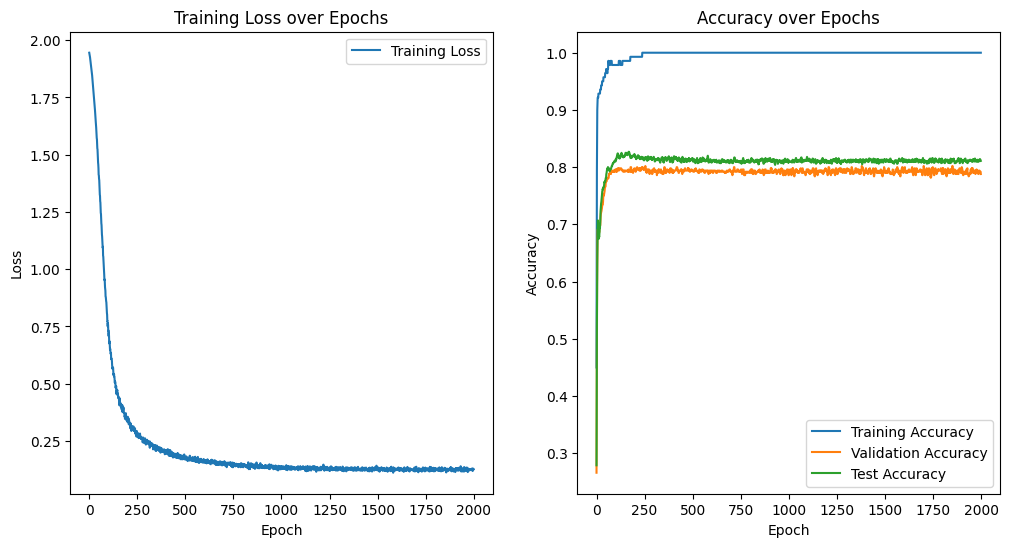

In [6]:
hiddennneuronnumber=128 #yukarda 16ydı
learningrate=0.002 #yukarda 0.01di
epochnumber=2000 #yukarda 200dü
actfunction =F.relu #yukarda F.relu ydu

class GCN(torch.nn.Module):
    def __init__(self,hiddenneuronnnumber=16):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hiddenneuronnnumber)
        self.conv2 = GCNConv(hiddenneuronnnumber, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = actfunction(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(hiddennneuronnumber)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

optimizer = optim.Adam(model.parameters(), lr=learningrate, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

# Eğitim ve değerlendirme sonuçlarını saklamak için listeler oluşturun
train_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Eğitim ve değerlendirme döngüsü
for epoch in range(0,epochnumber):
    loss = train()
    train_acc, val_acc, test_acc = test()
    train_losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    if epoch%200==0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

# Grafik çizimi
plt.figure(figsize=(12, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()



Hangi aktivasyon fonksiyonu daha iyi performans gösteriyor onu öğrenmek için aşşağııda test ediyorum bu esnada epoch sayısını düşürüyorum fikir vermesi amacıyla yaptığım bir test

In [7]:
actfunctions=[F.relu,F.elu,F.selu,F.leaky_relu,F.sigmoid,F.tanh,F.softplus,F.softshrink,F.softsign,F.hardshrink,F.hardsigmoid,F.hardtanh,F.hardswish,F.logsigmoid,F.softmin,F.softmax,F.softmin,F.softplus,F.softshrink,F.softsign,F.tanhshrink]
actfunctionperformances=[]

for a in actfunctions:
    hiddennneuronnumber=128 #yukarda 16ydı
    learningrate=0.002 #yukarda 0.01di
    epochnumber=100
    actfunction = a

    class GCN(torch.nn.Module):
        def __init__(self,hiddenneuronnnumber=16):
            super(GCN, self).__init__()
            self.conv1 = GCNConv(dataset.num_features, hiddenneuronnnumber)
            self.conv2 = GCNConv(hiddenneuronnnumber, dataset.num_classes)

        def forward(self, data):
            x, edge_index = data.x, data.edge_index
            x = self.conv1(x, edge_index)
            x = actfunction(x)
            x = F.dropout(x, training=self.training)
            x = self.conv2(x, edge_index)
            return F.log_softmax(x, dim=1)

    model = GCN(hiddennneuronnumber)
    print(model)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learningrate, weight_decay=5e-4)

    def train():
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        return loss.item()

    def test():
        model.eval()
        logits, accs = model(data), []
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

    # Eğitim ve değerlendirme sonuçlarını saklamak için listeler oluşturun
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    # Eğitim ve değerlendirme döngüsü
    for epoch in range(0,epochnumber):
        loss = train()
        train_acc, val_acc, test_acc = test()
        train_losses.append(loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        if epoch==99:
            print(f'Epoch: {epoch+1:03d},Activation Function: {actfunction} , Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

    actfunctionperformances.append(max(test_accuracies))

print("En iyi performansı veren aktivasyon fonksiyonu ve performansı:")
print(actfunctions[actfunctionperformances.index(max(actfunctionperformances))])
print(max(actfunctionperformances))


GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 100,Activation Function: <function relu at 0x00000254EF79E4D0> , Loss: 0.7599, Train Acc: 0.9857, Val Acc: 0.7960, Test Acc: 0.8170
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 100,Activation Function: <function elu at 0x00000254EF79E710> , Loss: 0.7018, Train Acc: 0.9857, Val Acc: 0.7980, Test Acc: 0.8130
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 100,Activation Function: <function selu at 0x00000254EF79E7A0> , Loss: 0.4332, Train Acc: 0.9857, Val Acc: 0.7920, Test Acc: 0.8180
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 100,Activation Function: <function leaky_relu at 0x00000254EF79E8C0> , Loss: 0.7508, Train Acc: 0.9786, Val Acc: 0.7940, Test Acc: 0.8140
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 100,Activation Function: <function sigmoid at 0x00000254EF79EF80> , Loss: 1.9409, Train Acc: 0.4500, Val Acc: 0.

C:\Users\xxtra\AppData\Local\Temp\ipykernel_30440\4113760315.py:19: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  x = actfunction(x)


Epoch: 100,Activation Function: <function softmin at 0x00000254EF79EC20> , Loss: 1.9416, Train Acc: 0.1643, Val Acc: 0.1660, Test Acc: 0.1390
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)


C:\Users\xxtra\AppData\Local\Temp\ipykernel_30440\4113760315.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = actfunction(x)


Epoch: 100,Activation Function: <function softmax at 0x00000254EF79ECB0> , Loss: 1.9417, Train Acc: 0.1571, Val Acc: 0.1680, Test Acc: 0.1420
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 100,Activation Function: <function softmin at 0x00000254EF79EC20> , Loss: 1.9419, Train Acc: 0.1643, Val Acc: 0.1580, Test Acc: 0.1410
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 100,Activation Function: <built-in function softplus> , Loss: 1.8475, Train Acc: 0.5500, Val Acc: 0.3240, Test Acc: 0.3420
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 100,Activation Function: <built-in function softshrink> , Loss: 1.9459, Train Acc: 0.1429, Val Acc: 0.0580, Test Acc: 0.0640
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 100,Activation Function: <function softsign at 0x00000254EF79EB00> , Loss: 0.7477, Train Acc: 0.9857, Val Acc: 0.7900, Test Acc: 0.8130
GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(1

Yukardaki testte en iyi çıkan aktivasyon fonksiyonunu kullanmaıyorum son modelin performansı aşşağıdaki gibidir.

GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)
Epoch: 001, Loss: 1.9465, Train Acc: 0.3357, Val Acc: 0.2280, Test Acc: 0.2620
Epoch: 201, Loss: 0.3384, Train Acc: 0.9929, Val Acc: 0.8020, Test Acc: 0.8300
Epoch: 401, Loss: 0.2067, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.8170
Epoch: 601, Loss: 0.1571, Train Acc: 1.0000, Val Acc: 0.7940, Test Acc: 0.8120
Epoch: 801, Loss: 0.1439, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.8150
Epoch: 1001, Loss: 0.1391, Train Acc: 1.0000, Val Acc: 0.7920, Test Acc: 0.8090
Epoch: 1201, Loss: 0.1174, Train Acc: 1.0000, Val Acc: 0.7920, Test Acc: 0.8070
Epoch: 1401, Loss: 0.1256, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.8080
Epoch: 1601, Loss: 0.1298, Train Acc: 1.0000, Val Acc: 0.8020, Test Acc: 0.8090
Epoch: 1801, Loss: 0.1250, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.8130


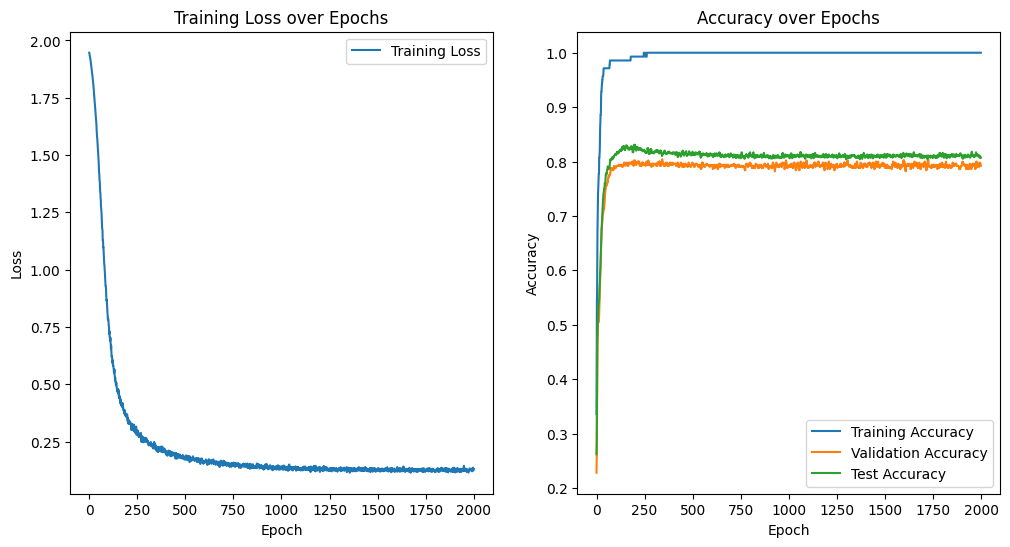

In [8]:
hiddennneuronnumber=128 #yukarda 16ydı
learningrate=0.002 #yukarda 0.01di
epochnumber=2000 #yukarda 200dü
actfunction =actfunctions[actfunctionperformances.index(max(actfunctionperformances))] #yukarda F.relu ydu

class GCN(torch.nn.Module):
    def __init__(self,hiddenneuronnnumber=16):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hiddenneuronnnumber)
        self.conv2 = GCNConv(hiddenneuronnnumber, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = actfunction(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(hiddennneuronnumber)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

optimizer = optim.Adam(model.parameters(), lr=learningrate, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

# Eğitim ve değerlendirme sonuçlarını saklamak için listeler oluşturun
train_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Eğitim ve değerlendirme döngüsü
for epoch in range(0,epochnumber):
    loss = train()
    train_acc, val_acc, test_acc = test()
    train_losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    if epoch%200==0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

# Grafik çizimi
plt.figure(figsize=(12, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()



Anlaşılırlığı daha iyi olması için nodeların birbirine olan uzaklığını k parametresi ile normalize ediyorum ve grafiğin görsel parametrelerini değiştiriyorum

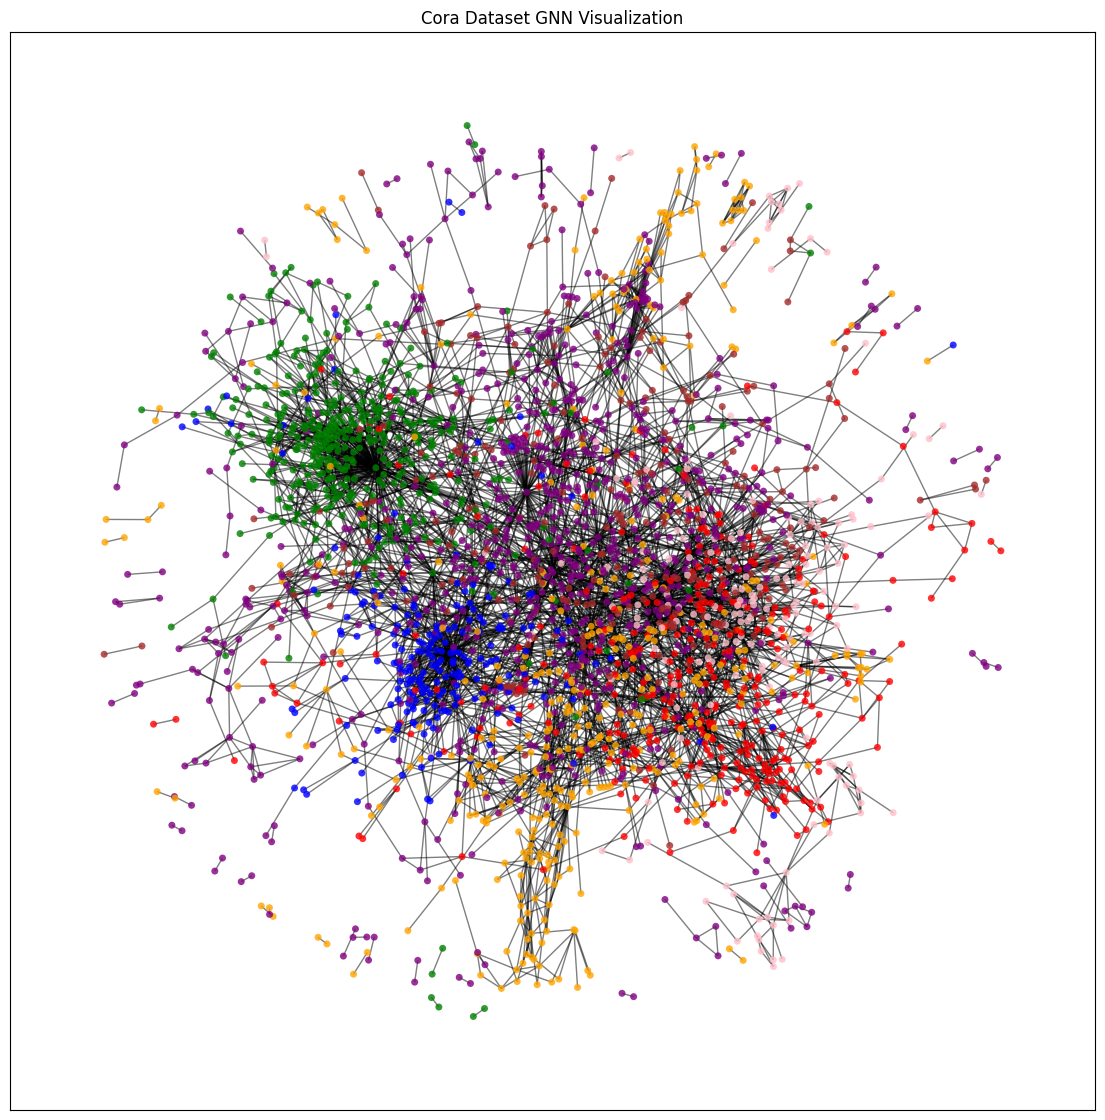

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Cora veri setini bir NetworkX grafiğine dönüştür
G = to_networkx(data, to_undirected=True)

# Düğüm renklerini sınıflarına göre belirle
colors = [data.y[i].item() for i in range(data.num_nodes)]

# Sınıfları renklendirme için belirgin renkler
class_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'purple',
    4: 'orange',
    5: 'brown',
    6: 'pink'
}
node_colors = [class_colors[color] for color in colors]

# Grafiği çiz
plt.figure(figsize=(14, 14))

# Layout ayarı (spring_layout, daha okunabilir bir düzen sağlar)
pos = nx.spring_layout(G, seed=42,k=0.1,iterations=100)

# Düğümleri çiz
nx.draw_networkx_nodes(G, pos, node_size=25, node_color=node_colors, alpha=0.8,linewidths=0.01)

# Kenarları çiz
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Düğüm etiketleri (isteğe bağlı, düğüm id'lerini gösterir)
# nx.draw_networkx_labels(G, pos, font_size=8)

# Başlık ve gösterge
plt.title('Cora Dataset GNN Visualization')
plt.show()
